## Introduction

In [ ]:
import sys
import warnings

required_version = "3.11.11"
current_version = sys.version.split()[0]

if current_version != required_version:
    warnings.warn(f"⚠️ This notebook is tested to run with Python {required_version}. Proceeding may cause compatibility issues.")
    
print(f"Python version: {current_version}")

In [ ]:
print("Note: This notebook is tested to run on Kaggle GPU P100 environment only.")

In [1]:
!pip install datasets trl bitsandbytes accelerate rouge_score evaluate

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 348.0/348.0 kB 9.6 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 21.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 28.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 68.5 MB/s eta 

In [2]:
from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    HfArgumentParser,
    AutoTokenizer,
    TrainingArguments,
    Trainer,
    GenerationConfig,
    set_seed
)
from tqdm import tqdm
from trl import SFTTrainer
import torch
import time
import pandas as pd
import numpy as np
import os
import random
from pynvml import *
from functools import partial

2025-05-12 22:22:16.830369: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747088537.021653      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747088537.073431      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
os.environ['WANDB_DISABLED']="true"

In [4]:
GLOBAL_SEED = 42

random.seed(GLOBAL_SEED)

np.random.seed(GLOBAL_SEED)

torch.manual_seed(GLOBAL_SEED)
torch.cuda.manual_seed_all(GLOBAL_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

set_seed(GLOBAL_SEED)

print(f"All random seeds have been set to {GLOBAL_SEED} for reproducibility.")

All random seeds have been set to 42 for reproducibility.


## Dataset preparation

In [5]:
huggingface_dataset_name = "abisee/cnn_dailymail"
dataset = load_dataset(huggingface_dataset_name, "3.0.0") 
dataset

README.md:   0%|          | 0.00/15.6k [00:00<?, ?B/s]

train-00000-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

train-00001-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

train-00002-of-00003.parquet:   0%|          | 0.00/259M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/34.7M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/30.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/287113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13368 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11490 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 287113
    })
    validation: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 13368
    })
    test: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 11490
    })
})

In [6]:
dataset['train'][0]

{'article': 'LONDON, England (Reuters) -- Harry Potter star Daniel Radcliffe gains access to a reported £20 million ($41.1 million) fortune as he turns 18 on Monday, but he insists the money won\'t cast a spell on him. Daniel Radcliffe as Harry Potter in "Harry Potter and the Order of the Phoenix" To the disappointment of gossip columnists around the world, the young actor says he has no plans to fritter his cash away on fast cars, drink and celebrity parties. "I don\'t plan to be one of those people who, as soon as they turn 18, suddenly buy themselves a massive sports car collection or something similar," he told an Australian interviewer earlier this month. "I don\'t think I\'ll be particularly extravagant. "The things I like buying are things that cost about 10 pounds -- books and CDs and DVDs." At 18, Radcliffe will be able to gamble in a casino, buy a drink in a pub or see the horror film "Hostel: Part II," currently six places below his number one movie on the UK box office char

In [7]:
combined_dataset = {
    'train': dataset['train'],
    'validation': dataset['validation'],
    'test': dataset['test']
}

train_size = len(combined_dataset['train'])
validation_size = len(combined_dataset['validation'])
test_size = len(combined_dataset['test'])
total_size = train_size + validation_size + test_size

print(f"Total dataset size: {total_size}")

Total dataset size: 311971


In [8]:
new_train_size = int(0.70 * total_size)
new_val_size = int(0.15 * total_size)
new_dev_size = int(0.10 * total_size)
new_test_size = int(0.05 * total_size)

print(f"New train size: {new_train_size}")
print(f"New validation size: {new_val_size}")
print(f"New dev size: {new_dev_size}")
print(f"New test size: {new_test_size}")

New train size: 218379
New validation size: 46795
New dev size: 31197
New test size: 15598


In [9]:
from datasets import concatenate_datasets

all_data = concatenate_datasets([
    dataset['train'],
    dataset['validation'],
    dataset['test']
])

shuffled_indices = np.random.permutation(len(all_data))
all_data = all_data.select(shuffled_indices)

new_train_size = int(0.70 * len(all_data))
new_val_size = int(0.15 * len(all_data))
new_dev_size = int(0.10 * len(all_data))
new_test_size = int(0.05 * len(all_data))

new_train_dataset = all_data.select(range(0, new_train_size))
new_val_dataset = all_data.select(range(new_train_size, new_train_size + new_val_size))
new_dev_dataset = all_data.select(range(new_train_size + new_val_size, new_train_size + new_val_size + new_dev_size))
new_test_dataset = all_data.select(range(new_train_size + new_val_size + new_dev_size, new_train_size + new_val_size + new_dev_size + new_test_size))

print(f"New train dataset size: {len(new_train_dataset)}")
print(f"New validation dataset size: {len(new_val_dataset)}")
print(f"New dev dataset size: {len(new_dev_dataset)}")
print(f"New test dataset size: {len(new_test_dataset)}")

New train dataset size: 218379
New validation dataset size: 46795
New dev dataset size: 31197
New test dataset size: 15598


## Model preparation

Quantization to load large model more efficiently

In [10]:
compute_dtype = getattr(torch, "float16")
bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type='nf4',
        bnb_4bit_compute_dtype=compute_dtype,
        bnb_4bit_use_double_quant=False,
    )
device_map = {"": 0}

In [11]:
model_name='microsoft/phi-2'
original_model = AutoModelForCausalLM.from_pretrained(model_name,
                                                      device_map=device_map,
                                                      quantization_config=bnb_config,
                                                      trust_remote_code=True)

config.json:   0%|          | 0.00/735 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/35.7k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/564M [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Tokenize dataset

In [12]:
tokenizer = AutoTokenizer.from_pretrained(model_name,trust_remote_code=True,padding_side="left",add_eos_token=True,add_bos_token=True,use_fast=False)
tokenizer.pad_token = tokenizer.eos_token

tokenizer_config.json:   0%|          | 0.00/7.34k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

In [13]:
eval_tokenizer = AutoTokenizer.from_pretrained(model_name, add_bos_token=True, trust_remote_code=True, use_fast=False)
eval_tokenizer.pad_token = eval_tokenizer.eos_token

In [14]:
def create_prompt_formats(sample):
    """
    Format various fields of the sample ('instruction','output')
    Then concatenate them using two newline characters
    :param sample: Sample dictionary
    """
    INTRO_BLURB = "Below is an instruction that describes a task. Write a response that appropriately completes the request."
    INSTRUCTION_KEY = "### Instruct: Summarize the below article."
    RESPONSE_KEY = "### Output:"
    END_KEY = "### End"

    blurb = f"\n{INTRO_BLURB}"
    instruction = f"{INSTRUCTION_KEY}"
    input_context = f"{sample['article']}" if sample["article"] else None
    response = f"{RESPONSE_KEY}\n{sample['highlights']}"
    end = f"{END_KEY}"

    parts = [part for part in [blurb, instruction, input_context, response, end] if part]

    formatted_prompt = "\n\n".join(parts)
    sample["text"] = formatted_prompt

    return sample

In [15]:
def preprocess_batch(batch, tokenizer, max_length):
    return tokenizer(
        batch["text"],
        max_length=max_length,
        truncation=True,
    )

In [16]:
def preprocess_dataset(tokenizer: AutoTokenizer, max_length: int, seed, dataset):
    """Format & tokenize it so it is ready for training
    :param tokenizer (AutoTokenizer): Model Tokenizer
    :param max_length (int): Maximum number of tokens to emit from tokenizer
    """

    print("Preprocessing dataset...")
    dataset = dataset.map(create_prompt_formats)

    _preprocessing_function = partial(preprocess_batch, max_length=max_length, tokenizer=tokenizer)
    dataset = dataset.map(
        _preprocessing_function,
        batched=True,
        remove_columns=['id', 'article', 'highlights'],  # Updated column names
    )

    dataset = dataset.filter(lambda sample: len(sample["input_ids"]) < max_length)

    dataset = dataset.shuffle(seed=seed)

    return dataset

In [17]:
def get_max_length(model):
    conf = model.config
    max_length = None
    for length_setting in ["n_positions", "max_position_embeddings", "seq_length"]:
        max_length = getattr(model.config, length_setting, None)
        if max_length:
            print(f"Found max lenth: {max_length}")
            break
    if not max_length:
        max_length = 1024
        print(f"Using default max length: {max_length}")
    return max_length

In [18]:
max_length = get_max_length(original_model)
print(f"Using max length: {max_length}")

Found max lenth: 2048
Using max length: 2048


In [19]:
train_dataset = preprocess_dataset(tokenizer, max_length, GLOBAL_SEED, new_train_dataset.select(range(210)))
eval_dataset = preprocess_dataset(tokenizer, max_length, GLOBAL_SEED, new_val_dataset.select(range(45)))
dev_dataset = preprocess_dataset(tokenizer, max_length, GLOBAL_SEED, new_dev_dataset.select(range(30)))
test_dataset = preprocess_dataset(tokenizer, max_length, GLOBAL_SEED, new_test_dataset.select(range(15)))

print(f"Shapes of the datasets:")
print(f"Training: {train_dataset.shape}")
print(f"Validation: {eval_dataset.shape}")
print(f"Dev: {dev_dataset.shape}")
print(f"Test: {test_dataset.shape}")

Preprocessing dataset...


Map:   0%|          | 0/210 [00:00<?, ? examples/s]

Map:   0%|          | 0/210 [00:00<?, ? examples/s]

Filter:   0%|          | 0/210 [00:00<?, ? examples/s]

Preprocessing dataset...


Map:   0%|          | 0/45 [00:00<?, ? examples/s]

Map:   0%|          | 0/45 [00:00<?, ? examples/s]

Filter:   0%|          | 0/45 [00:00<?, ? examples/s]

Preprocessing dataset...


Map:   0%|          | 0/30 [00:00<?, ? examples/s]

Map:   0%|          | 0/30 [00:00<?, ? examples/s]

Filter:   0%|          | 0/30 [00:00<?, ? examples/s]

Preprocessing dataset...


Map:   0%|          | 0/15 [00:00<?, ? examples/s]

Map:   0%|          | 0/15 [00:00<?, ? examples/s]

Filter:   0%|          | 0/15 [00:00<?, ? examples/s]

Shapes of the datasets:
Training: (203, 3)
Validation: (44, 3)
Dev: (28, 3)
Test: (15, 3)


Helper method to generate text based on prompt

In [20]:
def gen(model, p, maxlen=100, sample=True, seed=GLOBAL_SEED):
    toks = eval_tokenizer(p, return_tensors="pt")
    res = model.generate(
        **toks.to("cuda"), 
        max_new_tokens=maxlen, 
        do_sample=sample,
        num_return_sequences=1,
        temperature=0.1,
        num_beams=1,
        top_p=0.95,
    ).to('cpu')
    return eval_tokenizer.batch_decode(res, skip_special_tokens=True)

Try out to generate text with baseline model

In [21]:
%%time
index = 10

article = dataset['test'][index]['article']
summary = dataset['test'][index]['highlights']

formatted_prompt = f"Instruct: Summarize the following article.\n{article}\nOutput:\n"
res = gen(original_model, formatted_prompt, 100,)
output = res[0].split('Output:\n')[1]

dash_line = '-'.join('' for x in range(100))
print(dash_line)
print(f'INPUT PROMPT:\n{formatted_prompt}')
print(dash_line)
print(f'BASELINE HUMAN SUMMARY:\n{summary}\n')
print(dash_line)
print(f'MODEL GENERATION - ZERO SHOT:\n{output}')

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


---------------------------------------------------------------------------------------------------
INPUT PROMPT:
Instruct: Summarize the following article.
London (CNN)A 19-year-old man was charged Wednesday with terror offenses after he was arrested as he returned to Britain from Turkey, London's Metropolitan Police said. Yahya Rashid, a UK national from northwest London, was detained at Luton airport on Tuesday after he arrived on a flight from Istanbul, police said. He's been charged with engaging in conduct in preparation of acts of terrorism, and with engaging in conduct with the intention of assisting others to commit acts of terrorism. Both charges relate to the period between November 1 and March 31. Rashid is due to appear in Westminster Magistrates' Court on Wednesday, police said. CNN's Lindsay Isaac contributed to this report.
Output:

---------------------------------------------------------------------------------------------------
BASELINE HUMAN SUMMARY:
London's Metrop

In [22]:
def print_gpu_utilization():
    nvmlInit()
    handle = nvmlDeviceGetHandleByIndex(0)
    info = nvmlDeviceGetMemoryInfo(handle)
    print(f"GPU memory occupied: {info.used//1024**2} MB.")

In [23]:
def print_number_of_trainable_model_parameters(model):
    trainable_model_params = 0
    all_model_params = 0
    for _, param in model.named_parameters():
        all_model_params += param.numel()
        if param.requires_grad:
            trainable_model_params += param.numel()
    return f"trainable model parameters: {trainable_model_params}\nall model parameters: {all_model_params}\npercentage of trainable model parameters: {100 * trainable_model_params / all_model_params:.2f}%"

Compare original model with ones that will have LoRA Adapter attached. LoRA is used to help fine-tune more efficiently

In [24]:
print(print_number_of_trainable_model_parameters(original_model))

trainable model parameters: 262364160
all model parameters: 1521392640
percentage of trainable model parameters: 17.24%


In [25]:
print(original_model)

PhiForCausalLM(
  (model): PhiModel(
    (embed_tokens): Embedding(51200, 2560)
    (layers): ModuleList(
      (0-31): 32 x PhiDecoderLayer(
        (self_attn): PhiAttention(
          (q_proj): Linear4bit(in_features=2560, out_features=2560, bias=True)
          (k_proj): Linear4bit(in_features=2560, out_features=2560, bias=True)
          (v_proj): Linear4bit(in_features=2560, out_features=2560, bias=True)
          (dense): Linear4bit(in_features=2560, out_features=2560, bias=True)
        )
        (mlp): PhiMLP(
          (activation_fn): NewGELUActivation()
          (fc1): Linear4bit(in_features=2560, out_features=10240, bias=True)
          (fc2): Linear4bit(in_features=10240, out_features=2560, bias=True)
        )
        (input_layernorm): LayerNorm((2560,), eps=1e-05, elementwise_affine=True)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (rotary_emb): PhiRotaryEmbedding()
    (embed_dropout): Dropout(p=0.0, inplace=False)
    (final_layernorm): 

In [26]:
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training

config = LoraConfig(
    r=32,
    lora_alpha=32,
    target_modules=[
        'q_proj',
        'k_proj',
        'v_proj',
        'dense'
    ],
    bias="none",
    lora_dropout=0.05,
    task_type="CAUSAL_LM",
)

original_model.gradient_checkpointing_enable()

original_model = prepare_model_for_kbit_training(original_model)

peft_model = get_peft_model(original_model, config)

In [27]:
print(print_number_of_trainable_model_parameters(peft_model))

trainable model parameters: 20971520
all model parameters: 1542364160
percentage of trainable model parameters: 1.36%


In [28]:
print(peft_model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): PhiForCausalLM(
      (model): PhiModel(
        (embed_tokens): Embedding(51200, 2560)
        (layers): ModuleList(
          (0-31): 32 x PhiDecoderLayer(
            (self_attn): PhiAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=2560, out_features=2560, bias=True)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=2560, out_features=32, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=32, out_features=2560, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj): lora.Linear4b

## Model Training

In [29]:
print_gpu_utilization()

GPU memory occupied: 3708 MB.


In [30]:
output_dir = './peft-dialogue-summary-training/final-checkpoint'
import transformers

peft_training_args = TrainingArguments(
    output_dir = output_dir,
    per_device_train_batch_size=1,
    gradient_accumulation_steps=4,
    max_steps=10,
    learning_rate=2e-4,
    optim="paged_adamw_8bit",
    logging_steps=10,
    logging_dir="./logs",
    save_strategy="steps",
    save_steps=10,
    eval_strategy="steps",
    eval_steps=10,
    num_train_epochs=1,
    do_eval=True,
    gradient_checkpointing=True,
    report_to="none",
    overwrite_output_dir = 'True',
    group_by_length=True,
    seed=GLOBAL_SEED,
    data_seed=GLOBAL_SEED
)

peft_model.config.use_cache = False

peft_trainer = transformers.Trainer(
    model=peft_model,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    args=peft_training_args,
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)


No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [31]:
peft_training_args.device

device(type='cuda', index=0)

In [32]:
peft_trainer.train()

Step,Training Loss,Validation Loss
10,2.437600,2.414258


TrainOutput(global_step=10, training_loss=2.4376129150390624, metrics={'train_runtime': 213.907, 'train_samples_per_second': 0.187, 'train_steps_per_second': 0.047, 'total_flos': 667241004165120.0, 'train_loss': 2.4376129150390624, 'epoch': 0.19704433497536947})

Free memory for further steps

In [33]:
print_gpu_utilization()

GPU memory occupied: 14830 MB.


In [34]:
print_gpu_utilization()

GPU memory occupied: 14830 MB.


## Model Evaluation

In [35]:
print("Evaluating on Dev split...")
dev_results = peft_trainer.evaluate(dev_dataset)
print(f"Dev set evaluation results:")
print(dev_results)

Evaluating on Dev split...


Dev set evaluation results:
{'eval_loss': 2.339982748031616, 'eval_runtime': 43.7738, 'eval_samples_per_second': 0.64, 'eval_steps_per_second': 0.091, 'epoch': 0.19704433497536947}


In [36]:
print("Performing final evaluation on Test split...")
test_results = peft_trainer.evaluate(test_dataset)
print(f"Final test set evaluation results:")
print(test_results)

Performing final evaluation on Test split...
Final test set evaluation results:
{'eval_loss': 2.446943998336792, 'eval_runtime': 30.9891, 'eval_samples_per_second': 0.484, 'eval_steps_per_second': 0.065, 'epoch': 0.19704433497536947}


In [37]:
import pandas as pd
import evaluate
import torch
import numpy as np

articles = new_test_dataset[15:25]['article']
human_baseline_summaries = new_test_dataset[15:25]['highlights']

original_model_summaries = []
peft_model_summaries = []

for idx, article in enumerate(articles):
    human_baseline_text_output = human_baseline_summaries[idx]
    
    prompt = f"\nBelow is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruct: Summarize the below article.\n\n{article}\n\n### Output:\n"

    original_model_res = gen(original_model, prompt, 150)
    
    try:
        if '### Output:' in original_model_res[0]:
            original_model_text_output = original_model_res[0].split('### Output:')[1].strip()
        elif 'Output:' in original_model_res[0]:
            original_model_text_output = original_model_res[0].split('Output:')[1].strip()
        else:
            original_model_text_output = original_model_res[0]
    except Exception as e:
        print(f"Error parsing original model output for article {idx}: {e}")
        original_model_text_output = "[Parsing error]"

    peft_model_res = gen(peft_model, prompt, 150)
    
    try:
        if '### Output:' in peft_model_res[0]:
            peft_model_output = peft_model_res[0].split('### Output:')[1].strip()
        elif 'Output:' in peft_model_res[0]:
            peft_model_output = peft_model_res[0].split('Output:')[1].strip()
        else:
            peft_model_output = peft_model_res[0]
            
        for marker in ['### End', '#End', '##OUTPUT', '##End']:
            if marker in peft_model_output:
                peft_model_text_output = peft_model_output.split(marker)[0].strip()
                break
        else:
            peft_model_text_output = peft_model_output.strip()
            
    except Exception as e:
        print(f"Error parsing PEFT model output for article {idx}: {e}")
        peft_model_text_output = "[Parsing error]"

    original_model_summaries.append(original_model_text_output)
    peft_model_summaries.append(peft_model_text_output)

zipped_summaries = list(zip(human_baseline_summaries, original_model_summaries, peft_model_summaries))

df = pd.DataFrame(zipped_summaries, columns = ['human_baseline_summaries', 'original_model_summaries', 'peft_model_summaries'])
df

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

,human_baseline_summaries,original_model_summaries,peft_model_summaries
0,France announces new ministers .\nThe governme...,"A new French government was announced Tuesday,...",A new French government was announced on Tuesd...
1,Miss California USA Carrie Prejean says she po...,A second lingerie-modeling photo of Miss Calif...,A second lingerie-modeling photo of Miss Calif...
2,Jay-Z reported to be 'deeply disappointed' by ...,Rihanna was pictured out in London today looki...,Rihanna was pictured out in London today looki...
3,Carbisdale Castle near Culrain is nestled on p...,"Carbisdale Castle, near the village of Culrain...","Carbisdale Castle, near the Highland village o..."
4,Police collated the four-page dossier followin...,An unnamed hit band from the 1960s attended th...,An unnamed hit band from the 1960s attended th...
5,She still owns £3.9 million stately home in Ea...,Heather Mills has sold her British beachfront ...,Heather Mills has sold her British beachfront ...
6,Mitt Romney is trying to outdo President Obama...,The article is about how Mitt Romney is trying...,The article is about how Mitt Romney is trying...
7,Archaeologists believe site was centre of a ne...,The article describes how archaeologists have ...,The article discusses the latest discovery of ...
8,Edward Snowden claimed that a damaging culture...,"Edward Snowden, who worked as a contract emplo...","Edward Snowden, who worked as a contract emplo..."
9,Enterovirus D68 is sending children with breat...,Enterovirus D68 has swept through 30 states si...,Enterovirus D68 has swept through 30 states si...


In [43]:
import evaluate
rouge = evaluate.load('rouge')

original_model_results = rouge.compute(
    predictions=original_model_summaries,
    references=human_baseline_summaries[0:len(original_model_summaries)],
    use_aggregator=True,
    use_stemmer=True,
)

peft_model_results = rouge.compute(
    predictions=peft_model_summaries,
    references=human_baseline_summaries[0:len(peft_model_summaries)],
    use_aggregator=True,
    use_stemmer=True,
)

bleu = evaluate.load('bleu')

original_model_bleu = bleu.compute(
    predictions=original_model_summaries,
    references=[[ref] for ref in human_baseline_summaries]
)

peft_model_bleu = bleu.compute(
    predictions=peft_model_summaries, 
    references=[[ref] for ref in human_baseline_summaries]
)

def calculate_perplexity_alt(model, tokenizer, texts, max_loss=20.0):
    perplexities = []
    
    with torch.no_grad():
        for text in texts:
            try:
                inputs = tokenizer(text, return_tensors="pt")
                inputs = {k: v.to(model.device) for k, v in inputs.items()}
                
                outputs = model(**inputs)
                logits = outputs.logits
                
                shift_logits = logits[..., :-1, :].contiguous()
                shift_labels = inputs['input_ids'][..., 1:].contiguous()
                
                loss_fct = torch.nn.CrossEntropyLoss(reduction='mean')
                loss = loss_fct(shift_logits.reshape(-1, shift_logits.size(-1)), 
                              shift_labels.reshape(-1))
                
                loss = torch.clamp(loss, 0, max_loss)
                
                perplexity = torch.exp(loss)
                
                if not torch.isnan(perplexity) and not torch.isinf(perplexity):
                    perplexities.append(perplexity.item())
            except Exception as e:
                print(f"Error processing text: {e}")
                continue
    
    if not perplexities:
        return float('nan')
    
    return sum(perplexities) / len(perplexities)

original_perplexity = calculate_perplexity_alt(original_model, eval_tokenizer, human_baseline_summaries)
peft_perplexity = calculate_perplexity_alt(peft_model, eval_tokenizer, peft_model_summaries)

def format_metrics(rouge_results, bleu_results, perplexity):
    print("=== ROUGE Scores ===")
    for metric, value in rouge_results.items():
        print(f"  {metric}: {value*100:.2f}%")
    
    print("\n=== BLEU Score ===")
    print(f"  BLEU: {bleu_results['bleu']*100:.2f}%")
    print("  Precision by n-gram:")
    for n, precision in enumerate(bleu_results['precisions'], 1):
        print(f"    {n}-gram: {precision*100:.2f}%")
    
    print(f"\n=== Perplexity ===")
    print(f"  {perplexity:.4f} (lower is better)")

print("\n" + "="*50)
print("ORIGINAL MODEL EVALUATION")
print("="*50)
format_metrics(original_model_results, original_model_bleu, original_perplexity)

print("\n\n" + "="*50)
print("PEFT MODEL EVALUATION")
print("="*50)
format_metrics(peft_model_results, peft_model_bleu, peft_perplexity)


ORIGINAL MODEL EVALUATION
=== ROUGE Scores ===
  rouge1: 31.80%
  rouge2: 9.84%
  rougeL: 19.20%
  rougeLsum: 23.78%

=== BLEU Score ===
  BLEU: 4.67%
  Precision by n-gram:
    1-gram: 22.34%
    2-gram: 6.16%
    3-gram: 2.87%
    4-gram: 1.20%

=== Perplexity ===
  44.5138 (lower is better)


PEFT MODEL EVALUATION
=== ROUGE Scores ===
  rouge1: 31.32%
  rouge2: 10.37%
  rougeL: 19.25%
  rougeLsum: 24.23%

=== BLEU Score ===
  BLEU: 4.68%
  Precision by n-gram:
    1-gram: 21.94%
    2-gram: 6.24%
    3-gram: 2.80%
    4-gram: 1.25%

=== Perplexity ===
  11.9945 (lower is better)


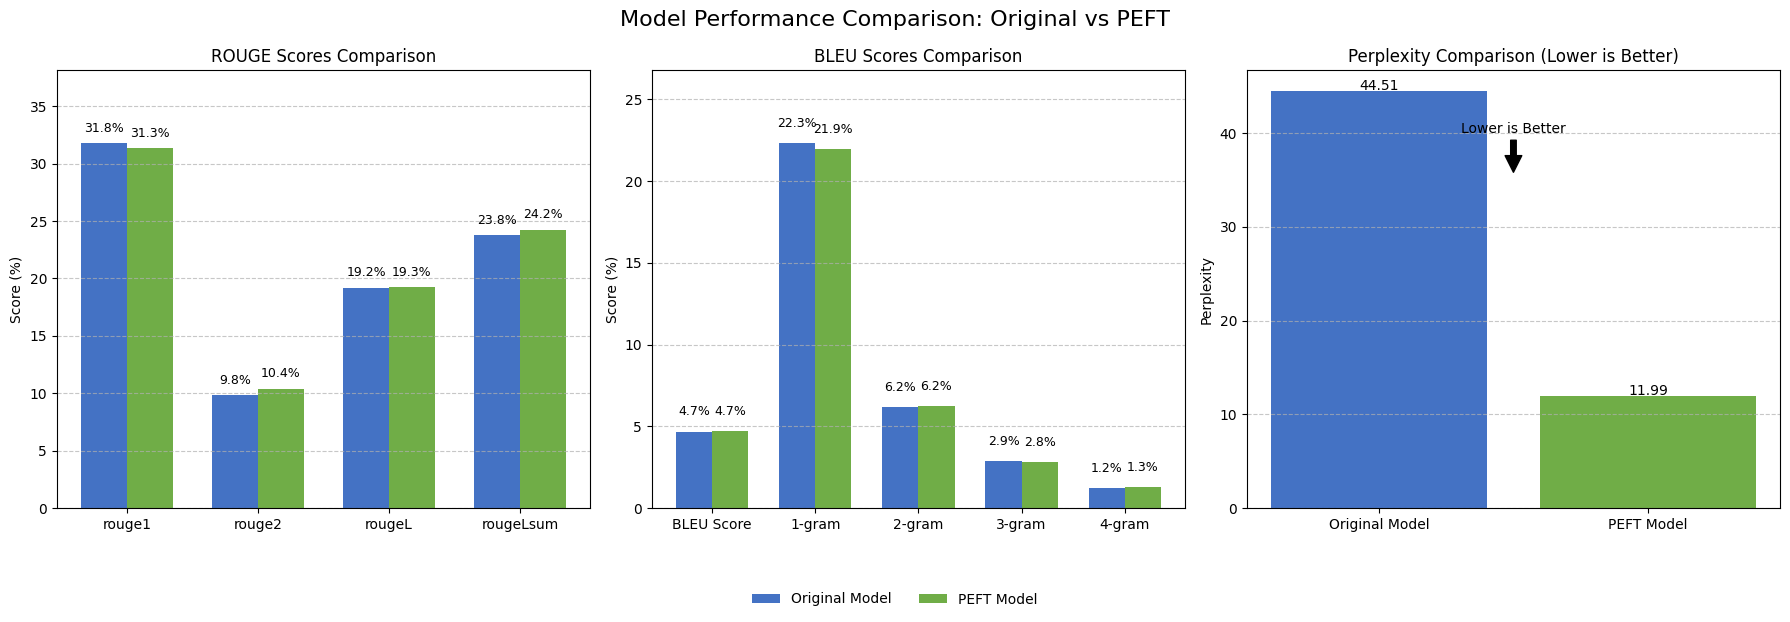


--- Performance Improvement Summary ---
BLEU Score: 0.01% absolute improvement
ROUGE Scores: rouge1: -0.48%, rouge2: 0.54%, rougeL: 0.05%, rougeLsum: 0.45% absolute improvement
Perplexity: 73.05% reduction (lower is better)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Model Performance Comparison: Original vs PEFT', fontsize=16)

original_color = '#4472C4'  # blue
peft_color = '#70AD47'      # green

# 1. ROUGE scores comparison
rouge_metrics = list(original_model_results.keys())
x = np.arange(len(rouge_metrics))
width = 0.35

original_rouge_values = [original_model_results[metric] * 100 for metric in rouge_metrics]
peft_rouge_values = [peft_model_results[metric] * 100 for metric in rouge_metrics]

ax1.bar(x - width/2, original_rouge_values, width, label='Original Model', color=original_color)
ax1.bar(x + width/2, peft_rouge_values, width, label='PEFT Model', color=peft_color)

ax1.set_title('ROUGE Scores Comparison')
ax1.set_ylabel('Score (%)')
ax1.set_xticks(x)
ax1.set_xticklabels(rouge_metrics)
ax1.set_ylim(0, max(max(original_rouge_values), max(peft_rouge_values)) * 1.2)
ax1.grid(axis='y', linestyle='--', alpha=0.7)

for i, v in enumerate(original_rouge_values):
    ax1.text(i - width/2, v + 1, f'{v:.1f}%', ha='center', fontsize=9)
    
for i, v in enumerate(peft_rouge_values):
    ax1.text(i + width/2, v + 1, f'{v:.1f}%', ha='center', fontsize=9)

# 2. BLEU score comparison
metrics = ['BLEU Score'] + [f'{i}-gram' for i in range(1, 5)]
x = np.arange(len(metrics))

original_bleu_values = [original_model_bleu['bleu'] * 100] + [p * 100 for p in original_model_bleu['precisions']]
peft_bleu_values = [peft_model_bleu['bleu'] * 100] + [p * 100 for p in peft_model_bleu['precisions']]

ax2.bar(x - width/2, original_bleu_values, width, label='Original Model', color=original_color)
ax2.bar(x + width/2, peft_bleu_values, width, label='PEFT Model', color=peft_color)

ax2.set_title('BLEU Scores Comparison')
ax2.set_ylabel('Score (%)')
ax2.set_xticks(x)
ax2.set_xticklabels(metrics)
ax2.set_ylim(0, max(max(original_bleu_values), max(peft_bleu_values)) * 1.2)
ax2.grid(axis='y', linestyle='--', alpha=0.7)

for i, v in enumerate(original_bleu_values):
    ax2.text(i - width/2, v + 1, f'{v:.1f}%', ha='center', fontsize=9)
    
for i, v in enumerate(peft_bleu_values):
    ax2.text(i + width/2, v + 1, f'{v:.1f}%', ha='center', fontsize=9)

# 3. Perplexity comparison (lower is better)
perplexity_data = [original_perplexity, peft_perplexity]
labels = ['Original Model', 'PEFT Model']
colors = [original_color, peft_color]

ax3.bar(labels, perplexity_data, color=colors)
ax3.set_title('Perplexity Comparison (Lower is Better)')
ax3.set_ylabel('Perplexity')
ax3.grid(axis='y', linestyle='--', alpha=0.7)

for i, v in enumerate(perplexity_data):
    ax3.text(i, v + 0.1, f'{v:.2f}', ha='center')

# Add an arrow indicating that lower is better for perplexity
max_perplexity = max(perplexity_data)
ax3.annotate('Lower is Better', 
             xy=(0.5, max_perplexity * 0.8), 
             xytext=(0.5, max_perplexity * 0.9),
             arrowprops=dict(facecolor='black', shrink=0.05),
             ha='center')

fig.legend(['Original Model', 'PEFT Model'], loc='upper center', ncol=2, bbox_to_anchor=(0.5, 0.03), frameon=False)

plt.tight_layout()
plt.subplots_adjust(top=0.88, bottom=0.15)

plt.show()

print("\n--- Performance Improvement Summary ---")
print(f"BLEU Score: {bleu_improvement:.2f}% absolute improvement")

rouge_improvements = []
for metric in original_model_results.keys():
    improvement = (peft_model_results[metric] - original_model_results[metric]) * 100
    rouge_improvements.append(f"{metric}: {improvement:.2f}%")
print(f"ROUGE Scores: {', '.join(rouge_improvements)} absolute improvement")

print(f"Perplexity: {perplexity_improvement_percent:.2f}% reduction (lower is better)")